In [31]:
## Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import linregress

In [ ]:
## Read files and data clean
def read_satellite_data(satellite):
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    df = df[df['veg_class'].isin([11, 12, 13, 14])]
    return df

Plot figure S4a

In [33]:
## Read AVHRR data, effect size data, then combine
satellite = "avhrr" 
df = read_satellite_data(satellite)

eos_cols = [col for col in df.columns if 'eos' in col]
t_cols = [col for col in df.columns if 'annual_t' in col]
p_cols = [col for col in df.columns if 'annual_p' in col]

years = [str(y) for y in range(1982, 2017)]
cols = years
# df = df[[col for col in eos_cols + t_cols + p_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
t_cols_df = [col for col in df.columns if 'annual_t' in col]
df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
df.columns = df.columns.str.replace(r'/D*(/d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
df_climate = df[['annual_t', 'annual_p', 'latitude', 'longitude']]
# print(df_climate)
effect_size = pd.read_csv(f"../data/effect_size/avhrr/effect_size_ate.csv")
effect_size = pd.merge(effect_size, df_climate, on=['latitude', 'longitude'], how='inner')
# effect_size
effect_size_hot_dry = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] > 7.25)]
effect_size_cold_dry = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] < 7.25)]
effect_size_wet = effect_size[effect_size['annual_p'] > 0.9]

In [ ]:
## Plot effect size for all variables
def plot_effect_size(df, name="Group", wet_threshold=0.9):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Identify all base variable prefixes (before "_w1")
    base_vars = [
        'sos_es',
        'spring_t_es', 'summer_t_es', 'autumn_t_es',
        'spring_p_es', 'summer_p_es', 'autumn_p_es',
        'spring_r_es', 'summer_r_es', 'autumn_r_es'
    ]

    df = df.dropna(subset=['annual_t']).copy()

    # Compute row-wise mean of all moving window columns
    for var in base_vars:
        window_cols = [col for col in df.columns if col.startswith(var + '_w')]
        if window_cols:
            df[var + '_mean'] = df[window_cols].mean(axis=1)

    effect_columns = [var + '_mean' for var in base_vars]

    # Define color/label maps
    color_map = {
        'sos_es_mean': '#ff69b4',
        'spring_t_es_mean': '#e9967a',
        'summer_t_es_mean': '#d47264',
        'autumn_t_es_mean': '#c14d48',
        'spring_p_es_mean': '#8ec1da',
        'summer_p_es_mean': '#4d91c4',
        'autumn_p_es_mean': '#2066a8',
        'spring_r_es_mean': '#d8c3e2',
        'summer_r_es_mean': '#a991c1',
        'autumn_r_es_mean': '#7a5fa0'
    }

    label_map = {
        'sos_es_mean': 'SOS',
        'spring_t_es_mean': 'Spring T',
        'summer_t_es_mean': 'Summer T',
        'autumn_t_es_mean': 'Autumn T',
        'spring_p_es_mean': 'Spring P',
        'summer_p_es_mean': 'Summer P',
        'autumn_p_es_mean': 'Autumn P',
        'spring_r_es_mean': 'Spring SR',
        'summer_r_es_mean': 'Summer SR',
        'autumn_r_es_mean': 'Autumn SR'
    }

    # Assign groups (cold, hot, wet)
    def assign_group(row):
        if row['annual_p'] > wet_threshold:
            return "Wet regions"
        elif row['annual_t'] < 7.25:
            return "Cold-dry regions"
        else:
            return "Hot-dry regions"

    df['climate_group'] = df.apply(assign_group, axis=1)

    # Keep only groups with at least 5 samples
    counts = df['climate_group'].value_counts()
    valid_groups = counts[counts >= 5].index
    df = df[df['climate_group'].isin(valid_groups)]

    # Compute stats
    grouped_stats = df.groupby('climate_group', observed=False)[effect_columns].agg(['mean', 'std', 'count'])
    for col in effect_columns:
        grouped_stats[(col, 'se')] = grouped_stats[(col, 'std')] / np.sqrt(grouped_stats[(col, 'count')])

    group_labels = ["Cold-dry regions", "Hot-dry regions", "Wet regions"]

    fig, axes = plt.subplots(len(group_labels), 1, figsize=(8, 9), sharex=True)

    for ax_idx, group in enumerate(group_labels):
        if group not in grouped_stats.index:
            continue
        ax = axes[ax_idx]
        means = [grouped_stats[(col, 'mean')].loc[group] for col in effect_columns]
        errors = [2 * grouped_stats[(col, 'se')].loc[group] for col in effect_columns]

        bars = ax.bar(
            np.arange(len(effect_columns)),
            means,
            yerr=errors,
            color=[color_map[col] for col in effect_columns],
            capsize=5
        )

        for bar in bars:
            height = bar.get_height()
            if height >= 0:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                        f"{height:.2f}", ha='center', va='bottom', fontsize=9)
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height - 0.02,
                        f"{height:.2f}", ha='center', va='top', fontsize=9)

        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax.text(0.01, 0.9, group, transform=ax.transAxes, fontsize=12, ha='left', va='top')
        ax.tick_params(axis='y', labelsize=11)
        ax.set_ylim(-0.30, 0.35)

        if ax_idx == len(group_labels)-1:  # only bottom subplot shows x labels
            ax.set_xticks(np.arange(len(effect_columns)))
            ax.set_xticklabels([label_map[col] for col in effect_columns],
                               rotation=45, ha='right', fontsize=12)
        else:
            ax.set_xticks([])

    # Shared Y label
    fig.text(0.01, 0.5, 'Effect Size', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0.05, 0, 1, 1])
    plt.show()
    return fig


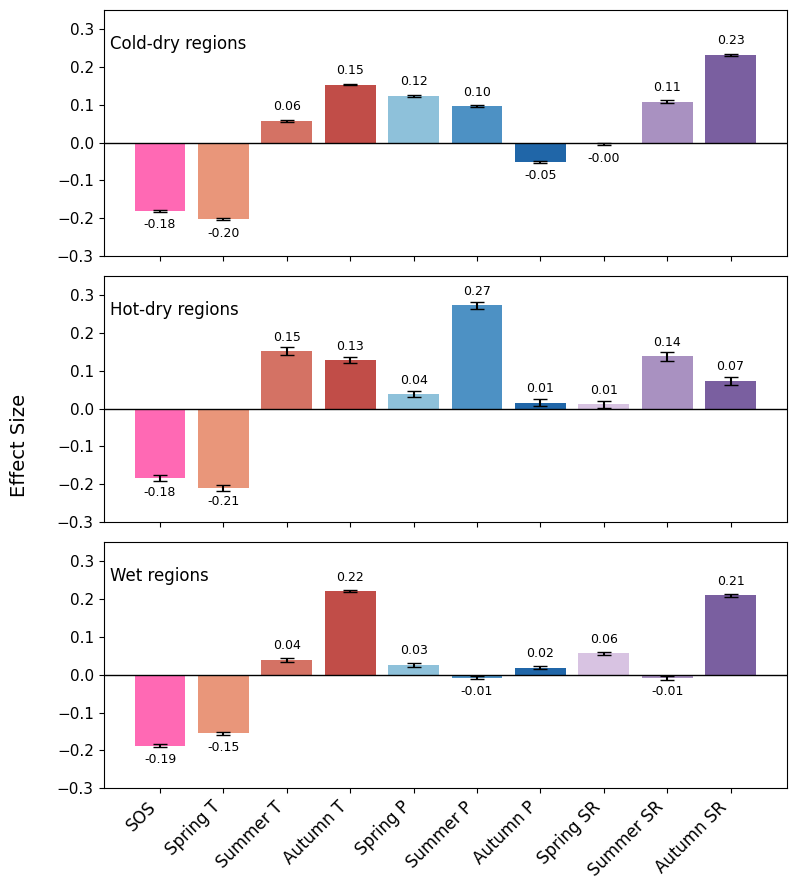

In [35]:
fig = plot_effect_size(effect_size)
fig.savefig("../results/si_figures/si_fig4/es_comparison.png", dpi=300, bbox_inches='tight')

In [67]:
## Read AVHRR data, effect size data, then combine
satellite = "avhrr" 
df = read_satellite_data(satellite)

eos_cols = [col for col in df.columns if 'eos' in col]
t_cols = [col for col in df.columns if 'annual_t' in col]
p_cols = [col for col in df.columns if 'annual_p' in col]

years = [str(y) for y in range(1982, 2017)]
cols = years
# df = df[[col for col in eos_cols + t_cols + p_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
t_cols_df = [col for col in df.columns if 'annual_t' in col]
df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
df.columns = df.columns.str.replace(r'/D*(/d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
df_climate = df[['annual_t', 'annual_p', 'latitude', 'longitude']]
# print(df_climate)
effect_size_82_00 = pd.read_csv(f"../data/effect_size/avhrr/effect_size_82_99_ate.csv")
effect_size_00_16 = pd.read_csv(f"../data/effect_size/avhrr/effect_size_00_16_ate.csv")
effect_size_82_00 = effect_size_82_00.rename(columns=lambda x: x.replace("w1", "82_99"))
effect_size_00_16 = effect_size_00_16.rename(columns=lambda x: x.replace("w1", "00_16"))

effect_size = pd.merge(effect_size_82_00, effect_size_00_16, on=['latitude', 'longitude'], how='inner')

effect_size = pd.merge(effect_size, df_climate, on=['latitude', 'longitude'], how='inner')
effect_size_hot_dry = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] > 7.25)]
effect_size_cold_dry = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] < 7.25)]
effect_size_wet = effect_size[effect_size['annual_p'] > 0.9]

In [71]:
## Temporal Comparison of Effect Sizes with Standard Errors and t-Tests
def plot_two_periods_subplot(ax, df, name, color_map, label_map):
    import numpy as np
    import pandas as pd
    import re
    from scipy.stats import ttest_ind
    # print(ax, df, name, color_map, label_map)
    # Regex to capture variable name and period
    pattern = re.compile(r"^(.*)_es_(\d{2}_\d{2})$")

    vars_periods = {}
    for col in df.columns:
        # print(col)
        match = pattern.match(col)
        if match:
            var, period = match.group(1), match.group(2)
            if var not in vars_periods:
                vars_periods[var] = {}
            vars_periods[var][period] = col
            
    # Helper to compute mean + SE
    def mean_and_se(series):
        values = series.dropna()
        if len(values) == 0:
            return np.nan, np.nan
        if len(values) == 1:
            return values.iloc[0], np.nan
        return values.mean(), values.std(ddof=1) / np.sqrt(len(values))

    group_means = {"82–99": {}, "00–16": {}}
    group_se = {"82–99": {}, "00–16": {}}
    p_values = {}

    for var, period_cols in vars_periods.items():
        vals1 = vals2 = None
        if "82_99" in period_cols:
            mean1, se1 = mean_and_se(df[period_cols["82_99"]])
            group_means["82–99"][var], group_se["82–99"][var] = mean1, se1
            vals1 = df[period_cols["82_99"]].dropna()
        if "00_16" in period_cols:
            mean2, se2 = mean_and_se(df[period_cols["00_16"]])
            group_means["00–16"][var], group_se["00–16"][var] = mean2, se2
            vals2 = df[period_cols["00_16"]].dropna()

        # significance test if both periods exist
        if vals1 is not None and vals2 is not None and len(vals1) > 1 and len(vals2) > 1:
            stat, p = ttest_ind(vals1, vals2, equal_var=True, nan_policy="omit")
            p_values[var] = p
        else:
            p_values[var] = np.nan

    # Bar plot setup
    variables = list(group_means["82–99"].keys())
    x = np.arange(len(variables))
    width = 0.42

    vals1 = [group_means["82–99"][var] for var in variables]
    se1 = [group_se["82–99"][var] for var in variables]
    vals2 = [group_means["00–16"][var] for var in variables]
    se2 = [group_se["00–16"][var] for var in variables]

    colors = [color_map.get(var, "black") for var in variables]

    # First period bars (1982–1999)
    ax.bar(
        x - width/2, vals1, width=width, color=colors, hatch="/",
        edgecolor="#3d3d3d", linewidth=0.8, label="1982–1999", yerr=[2*np.array(se1)], capsize=5
    )
    # Second period bars (2000–2016)
    ax.bar(
        x + width/2, vals2, width=width, color=colors, hatch="...",
        edgecolor="#3d3d3d", linewidth=0.8, label="2000–2016",
        yerr=[2*np.array(se2)], capsize=5, alpha=0.85
    )

    # Add significance markers (* for p<0.05, ** for p<0.01)
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    bracket_height = 0.03 * y_range   # fixed size for all brackets
    bracket_gap = 0.03 * y_range      # gap between bar top and bracket

    for i, var in enumerate(variables):
        if var in p_values and not np.isnan(p_values[var]):
            p = p_values[var]
            if p < 0.05:  # only plot if significant
                sig_symbol = "**" if p < 0.01 else "*"

                # bar heights
                y1 = vals1[i] + (se1[i] if se1[i] else 0)
                y2 = vals2[i] + (se2[i] if se2[i] else 0)

                if y1 >= 0 or y2 >= 0:
                    # at least one bar positive → put bracket above
                    y_base = max(y1, y2) + bracket_gap
                    text_va = "bottom"
                    bracket_dir = +1
                else:
                    # both negative → put bracket below
                    y_base = min(y1, y2) - bracket_gap
                    text_va = "top"
                    bracket_dir = -1

                # x positions for two bars
                x1 = i - width/2
                x2 = i + width/2

                # draw fixed-size bracket
                ax.plot(
                    [x1, x1, x2, x2],
                    [y_base,
                     y_base + bracket_dir * bracket_height,
                     y_base + bracket_dir * bracket_height,
                     y_base],
                    color="black", linewidth=0.5
                )

                # put significance symbol
                ax.text(
                    (x1 + x2) / 2,
                    y_base + bracket_dir * (bracket_height * 1),
                    sig_symbol,
                    ha="center", va=text_va,
                    fontsize=14, color="black"
                )


    # Decorations
    ax.text(0.01, 0.9, name, transform=ax.transAxes, fontsize=12, ha="left", va="top")
    ax.axhline(0, color="black", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(
        [label_map.get(var, var) for var in variables],
        rotation=45, ha="right", fontsize=12
    )
    ax.tick_params(axis="y", labelsize=12)


In [72]:
## Plot effect size of 3 periods
def plot_effect_size(dfs, names):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    color_map = {
        'sos': '#ff69b4',
        'spring_t': '#e9967a',
        'summer_t': '#d47264',
        'autumn_t': '#c14d48',
        'spring_p': '#8ec1da',
        'summer_p': '#4d91c4',
        'autumn_p': '#2066a8',
        'spring_r': '#d8c3e2',
        'summer_r': '#a991c1',
        'autumn_r': '#7a5fa0'
    }


    label_map = {
        'sos': 'SOS',
        'spring_t': 'Spring T',
        'summer_t': 'Summer T',
        'autumn_t': 'Autumn T',
        'spring_p': 'Spring P',
        'summer_p': 'Summer P',
        'autumn_p': 'Autumn P',
        'spring_r': 'Spring SR',
        'summer_r': 'Summer SR',
        'autumn_r': 'Autumn SR'
    }

    n = len(dfs)
    fig, axes = plt.subplots(n, 1, figsize=(8, 3*n), sharey=True)

    if n == 1:
        axes = [axes]  # ensure iterable

    for i, (df, name) in enumerate(zip(dfs, names)):
        plot_two_periods_subplot(axes[i], df, name, color_map, label_map)
        if i < n-1:
            axes[i].set_xticklabels([])   # remove x labels for upper plots
        axes[i].set_ylim(-0.40, 0.50)

    # Custom legend (for time windows)
    legend_elements = [
        Patch(facecolor='white', hatch='//', edgecolor='#3d3d3d', label='1982-1999', linewidth=1.0),
        Patch(facecolor='white', hatch='..', edgecolor='#3d3d3d', label='2000-2016', linewidth=1.0)
    ]
    axes[0].legend(handles=legend_elements, fontsize=11, frameon=False)

    # Shared y-label
    fig.text(0.01, 0.5, 'Effect Size', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0.05, 0, 1, 1])
    plt.show()
    return fig


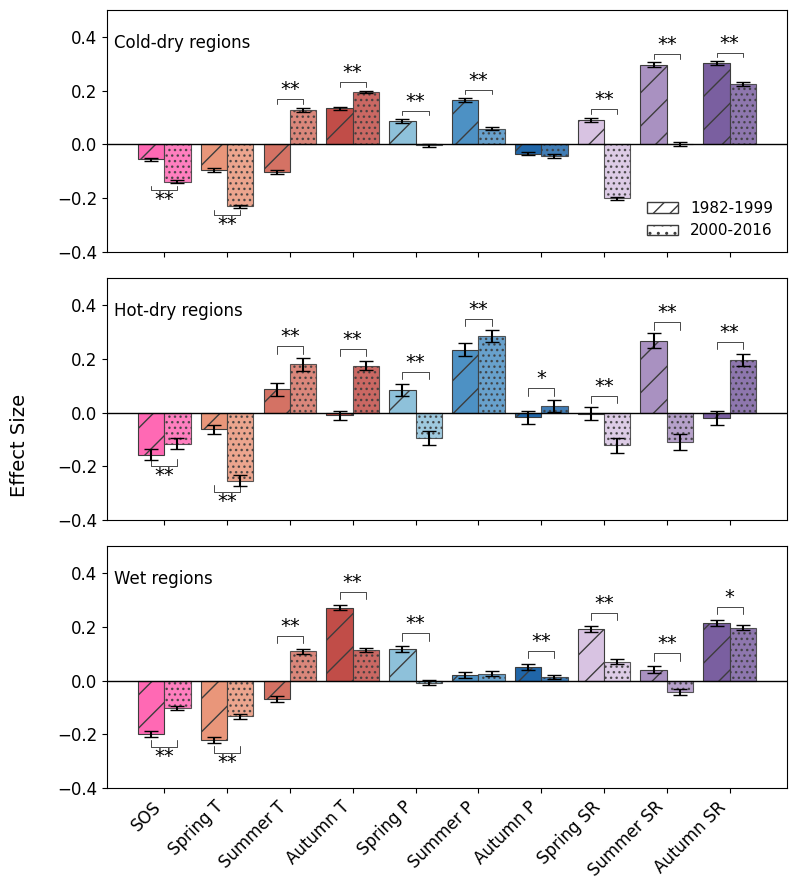

In [73]:
fig = plot_effect_size(
    [effect_size_cold_dry, effect_size_hot_dry, effect_size_wet],
    ["Cold-dry regions", "Hot-dry regions", "Wet regions"]
)

fig.savefig("../results/si_figures/si_fig4/es_comparison_temporal.png", dpi=300, bbox_inches='tight')